<h1 align="center">ADMM for Quadratic Programming</h1>

In this notebook, we implement the Alternating Direction Method of Multipliers algorithm for solving a standard-form Quadratic Program.  The ADMM approach solves convex optimization problems by breaking them into smaller pieces, each of which are then easier to handle.

The standard form QP is:

**Minimize $\dfrac {1} {2} x^T P x + q^T x + r$ subject to $lb \le x \le ub$.**

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Pure-Python ADMM Implementation

The code below is a direct Python port of the reference MATLAB implementation in Reference[1]. 

In [2]:
from numpy.linalg import cholesky, norm

def objective(P, q, r, x):
    """Return the value of the Standard form QP using the current value of x."""
    return 0.5 * np.dot(x, np.dot(P, x)) + np.dot(q, x) + r


def qp_admm(P, q, r, lb, ub,
            max_iter=1000,
            rho=1.0, 
            alpha=1.2,              
            atol=1e-4, 
            rtol=1e-2):

    n = P.shape[0]
    
    x = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n)
    
    history = []

    for k in range(1, max_iter+1):

        if k > 1:
            x = ((rho * (z - u) - q) / R.T) / R
        else:
            R = cholesky(P + rho * np.eye(n))
            x = ((rho * (z - u) - q) / R.T) / R
        
        x = np.diag(x)
        
        # z-update with relaxation
        z_old = z
        x_hat = alpha * x +(1 - alpha) * z_old
        z = np.minimum(ub, np.maximum(lb, x_hat + u))

        # u-update
        u = u + (x_hat - z)

        # diagnostics, and termination checks
        objval = objective(P, q, r, x)

        r_norm = norm(x - z)
        s_norm = norm(-rho * (z - z_old))
        eps_pri = np.sqrt(n) * atol + rtol * np.maximum(norm(x), norm(-z))
        eps_dual = np.sqrt(n)* atol + rtol * norm(rho*u)
        
        history.append({
            'objval'  : objval, 
            'r_norm'  : r_norm, 
            's_norm'  : s_norm,
            'eps_pri' : eps_pri,
            'eps_dual': eps_dual,
        })
        
        if r_norm < eps_pri and s_norm < eps_dual:
            print('Optimization terminated after {} iterations'.format(k))
            break;
        
    history = pd.DataFrame(history)
    return x, history


# QP Solver using CVXPY 
For comparison, we also implement QP solver using cvxpy.

In [3]:
import cvxpy as cvx

def qp_cvxpy(P, q, r, lb, ub,
            max_iter=1000,
            atol=1e-4, 
            rtol=1e-2):
    n = P.shape[0]
    
    # The variable we want to solve for
    x = cvx.Variable(n)
    constraints = [x >= cvx.Constant(lb), x <= cvx.Constant(ub)]
    
    # Construct the QP expression using CVX Primitives
    # Note that in the CVX-meta language '*' of vectors of matrices indicates dot product, 
    # not elementwise multiplication 
    expr = cvx.Constant(0.5) * cvx.quad_form(x, cvx.Constant(P)) + cvx.Constant(q) * x + cvx.Constant(r)
    qp = cvx.Problem(cvx.Minimize(expr), constraints=constraints)
    qp.solve(max_iters=max_iter, abstol=atol, reltol=rtol, verbose=True)    
    
    # The result is a Matrix object. Make it an NDArray and drop of 2nd dimension i.e. make it a vector.
    x_opt = np.array(x.value).squeeze()
    return x_opt

# Generate Optimal Portfolio Holdings

In this section, we define a helper function to load the one of the five asset returns datasets from OR library (Reference [2]). The data are available by requesting filenames `port[1-5]`. Each file contains a progressively larger set of asset returns, standard deviations of returns and correlations of returns.

In [4]:
import requests
from statsmodels.stats.moment_helpers import corr2cov
from functools import lru_cache

@lru_cache(maxsize=5)
def get_cov(filename):
    url = r'http://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/{}.txt'.format(filename)
    data = requests.get(url).text
    lines = [line.strip() for line in data.split('\n')]

    # First line is the number of assets
    n_assets = int(lines[0])
    
    # Next n_assets lines contain the space separated mean and stddev. of returns for each asset
    means_and_sds = pd.DataFrame(
        data=np.nan, 
        index=range(0, n_assets), 
        columns=['ret_mean', 'ret_std'])

    # Next n_assetsC2 lines contain the 1-based row and column index and the corresponding correlation
    for i in range(0, n_assets):
        mean, sd = map(float, lines[1+i].split())
        means_and_sds.loc[i, ['ret_mean', 'ret_std']] = [mean, sd]

    n_corrs = (n_assets * (n_assets + 1)) // 2
    corrs = pd.DataFrame(index=range(n_assets), columns=range(n_assets), data=np.nan)

    for i in range(0, n_corrs):
        row, col, corr = lines[n_assets + 1 + i].split()
        row, col = int(row)-1, int(col)-1
        corr = float(corr)
        corrs.loc[row, col] = corr
        corrs.loc[col, row] = corr
    
    cov = corr2cov(corrs, means_and_sds.ret_std)
    return cov

# Set up the Portfolio Optimization problem as a QP

In [5]:
from numpy.random import RandomState
rng = RandomState(0)
P = get_cov('port1')
n = P.shape[0]
alphas = rng.uniform(-0.4, 0.4, size=n) 
q = -alphas
ub = np.ones_like(q)
lb = np.zeros_like(q)
r = 0

# Using ADMM

In [6]:
%%time
x_opt_admm, history = qp_admm(P, q, r, lb, ub)

Optimization terminated after 50 iterations
Wall time: 24 ms


d:\Anaconda3\envs\crf\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
d:\Anaconda3\envs\crf\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
d:\Anaconda3\envs\crf\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


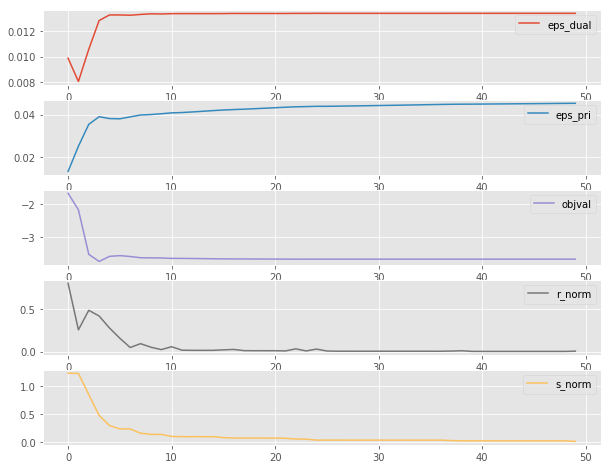

In [19]:
fig, ax = plt.subplots(history.shape[1], 1, figsize=(10, 8))
ax = history.plot(subplots=True, ax=ax, rot=0)

# Using CVXPY

In [7]:
%%time
x_opt_cvxpy = qp_cvxpy(P, q, r, lb, ub)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -8.349e-01  -3.800e+01  +2e+02  5e-01  5e-02  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  -3.017e+00  -7.175e+00  +6e+01  7e-02  1e-02  3e+00  1e+00  0.8488  4e-01   1  1  1 |  0  0
 2  -3.483e+00  -4.019e+00  +8e+00  6e-03  2e-03  2e-01  2e-01  0.9890  1e-01   1  1  1 |  0  0
 3  -3.622e+00  -3.763e+00  +2e+00  1e-03  3e-04  3e-02  4e-02  0.8776  1e-01   1  1  1 |  0  0
 4  -3.665e+00  -3.676e+00  +2e-01  1e-04  3e-05  2e-03  3e-03  0.9313  1e-02   1  1  1 |  0  0
 5  -3.669e+00  -3.670e+00  +3e-02  2e-05  4e-06  2e-04  5e-04  0.8740  4e-02   2  1  1 |  0  0
 6  -3.669e+00  -3.670e+00  +1e-02  6e-06  2e-06  6e-05  2e-04  0.7603  2e-01   2  1  1 |  0  0
 7  -3.669e+00  -3.669e+00  +1e-03  8e-07  2e-07  7e-06  2e-05  0.8847  1e-02   2  1  1 |  0  0
 8  -3.669e+00  -3.669e+00  +6e-05  3e-08  9e-

# Optimal Holdings Comparison

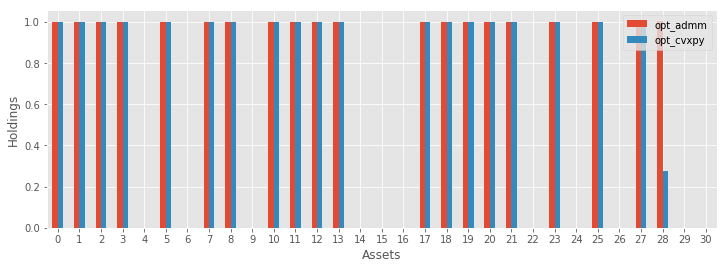

In [8]:
holdings = pd.DataFrame(np.column_stack([x_opt_admm, x_opt_cvxpy]), columns=['opt_admm', 'opt_cvxpy'])
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax = holdings.plot(kind='bar', ax=ax, rot=0)
labels = ax.set(xlabel='Assets', ylabel='Holdings')

# References

1. https://web.stanford.edu/~boyd/papers/admm/quadprog/quadprog.html
2. http://people.brunel.ac.uk/~mastjjb/jeb/orlib/portinfo.html